In [146]:
# %matplotlib notebook
# %pylab

In [147]:
# import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

### Generating the 2D Data

In [148]:
import pickle
import numpy as np
from scipy.spatial import distance
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import mpl_toolkits.mplot3d.axes3d as p3
from matplotlib.animation import FuncAnimation
import pandas as pd
import math
from mpl_toolkits.mplot3d import Axes3D
import itertools

### Experiment Function

In [149]:
STEP ='STEP'
EPISODE = 'EPISODE'
QUADRATIC='QUADRATIC'
COSINE ='COSINE'
CURRENT='CURRENT'# reward in state
DELAYED='DELAYED' # discounted future reward
CURRENT_DELAYED ='CURRENT_DELAYED' # current reward + discounted future reward

In [150]:
from experiment import *
name = "LimitedJump_1000_1DQ"
parameters={
            "exp": name,            #name of experiment
            "mode": EPISODE,           # two modes of execution, 1 episode(1000steps) or N episodes -[step, episode] 
            "data_dimension": 2,    # dimension of data, 1 to N Dimension
            "function":QUADRATIC,   # quadratic or cosine
            "queue_length": 5,      # max length of queue
            "heuristic_queue":2,    # sequeuce length that is considered by the heuristic
            "discount_factor": 0.9, # discount factor               
            "max_skip":1,           # maximum allowed skip 
            "e_start": 1,           # episilon value to start applying heuristic
            "e_stop":0.1,             # episilon value to stop applying heuristic
            "epi": 1000,             # number of episodes
            "learning_rate": 0.9,   # learning rate
            "reward":CURRENT,       # current/delayed/current_delayed
            "lambda":0.01,
            "min_skip":3, 
            "baseline":True,        # parameter to switch to baseline model(without heuristic)
            "num_step":1000
        }

#create_experiment(parameters)

In [151]:
exp = parameters

In [152]:
def styblinski_tang(x):
    """
    compute styblinski-tang optimization test function

    Args:
        x(array): array to compute the styblinki_tang value of

    Returs:
        the evaluated value of styblinki_tang function of x
    """
    result = x**4 - 16 * x**2 + 5 * x
    return result / 2



def rosenbrock(x):
    """
    Compute Rosenbrock test function for a single point

    Args:
        x(array): array to compute the rosenbrock value of

    Returs:
        the evaluated value of rosenbrock function of x
    """
    #print(x)
    #result = np.sum(100.0 * (x[1:] - x[:-1]**2.0) ** 2.0 + (1 - x[:-1])**2.0, axis=0)
    result = 100*(x[1]-x[0]**2)**2 + (x[0]-1)**2
    return result


def quadratic(x):
    """
    Compute quadratic test function for a single point

    Args:
        x(array): array to compute the rosenbrock value of

    Returs:
        the evaluated value of quadratic function of x
    """
    result = np.sum(0.3*x**2 -5, axis=0)

    return result

def camelback(x):
    #print(x)
    return ((4-2.1*x[0]**2 + (x[0]**4)/3)*x[0]**2 + x[0]*x[1] + (-4+4*(x[1]**2))*x[1]**2)

def griewank(x):
    return (x[0]**2)/4000+(x[1]**2)/4000 - np.cos(x[0])-np.cos(x[1]/2)+1

def eason(x):
    return -np.cos(x[0])*np.cos(x[1])*np.exp(-(x[0]-np.pi)**2-(x[1]-np.pi)**2)

def egg_holder(x):
    return -(x[1]+47)*np.sin(np.sqrt(abs(x[1]**2 + x[0]/2 + 47))) - x[0]*np.sin(np.sqrt(abs(x[0]-(x[1]+47))))
    
def array_map(f, x):
    return np.array(list(map(f, x)))

def quadratic_2d(x):
    A = np.matrix([[1, 0],[0, 2]])
    b = np.matrix([[0],[0]])
    c = 0
    return float(0.5 * x.T * A * x - b.T * x + c)

In [153]:
def bowl(f):
    fig = plt.figure(figsize=(10,8))
    qf = fig.gca(projection='3d')
    data_size =5
    x1 = list(np.arange(-data_size,data_size+1, 1))
    x2 = list(np.arange(-data_size, data_size+1, 1))
    size = len(x1)
    x1, x2 = np.meshgrid(x1, x2)
    zs = np.zeros((size, size))
    collector = []
    value = []
    for i in range(size):
        for j in range(size):
            x = np.matrix([[x1[i,j]], [x2[i,j]]])
            collector.append([x1[i,j], x2[i,j]])
            zs[i,j] = f(x)
            value .append(zs[i,j])
    qf.plot_surface(x1, x2, zs, rstride=1, cstride=1, linewidth=0)
    fig.show()
    return x1, x2, zs, collector, value

/home_nfs/djanden/ioi/exp/iopa/libiopa/experiment_design/work/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


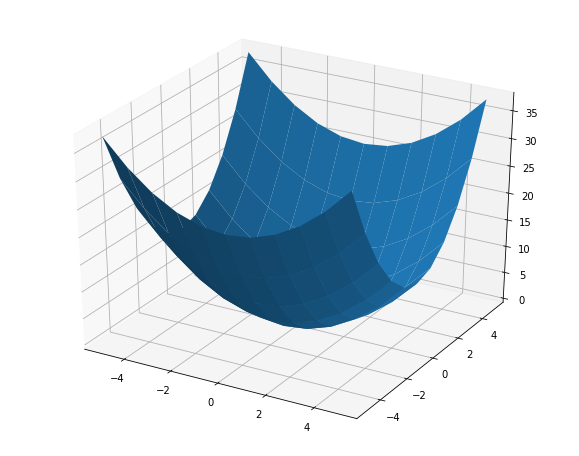

In [154]:
x1, x2, data, collector, value = bowl(quadratic_2d)

/home_nfs/djanden/ioi/exp/iopa/libiopa/experiment_design/work/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


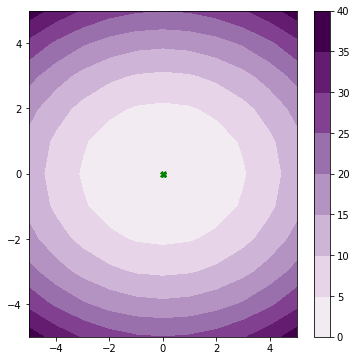

In [155]:
from matplotlib import cm

def contoursteps(x1, x2, zs, steps=None):
    fig = plt.figure(figsize=(6,6))
    levels = np.arange(-2.0, 1.601, 0.4)
    norm = cm.colors.Normalize(vmax=abs(zs).max(), vmin=-abs(zs).max())
    cmap = cm.PRGn
    cmap=cm.get_cmap(cmap, len(levels) - 1)
    cp = plt.contourf(x1, x2, zs, norm = norm, cmap=cmap.reversed())
    plt.plot(0, 0, 'X', color='green')
    fig.colorbar(cp)
    #plt.clabel(cp, inline=1, fontsize=10)
    if steps is not None:
        step =steps
        steps = np.matrix(steps)
        plt.plot(steps[:,0], steps[:,1], '-o', color='red')
#     for i, txt in enumerate(len(step)):
#         fig.annotate(value, (z[i], y[i]))
    fig.show()
    
steps = None#[(-40,-40),(-35,-25), (-30,-20),(-10,-5),(0,3)]
contoursteps(x1, x2, data, steps)

In [156]:
data_df = pd.DataFrame({"collector":collector,"duration":value})


In [157]:
data_df.tail()

,collector,duration
116,"[1, 5]",25.5
117,"[2, 5]",27.0
118,"[3, 5]",29.5
119,"[4, 5]",33.0
120,"[5, 5]",37.5


### Utilities

In [158]:
def action_space(dim, max_skip=7):

    length = 2 * max_skip * dim +1
    res = np.zeros((length, dim))
    j=1
    for i in range(0, dim):
        for skip in range(1, max_skip+1):
            res[j][i]= -skip
            j+=1
            res[j][i]=skip
            j+=1
    if dim==1:
        res1 = [ x[0] for x in res ]
        res = res1[:]
        return res
        
    return res.astype(int).tolist()

In [159]:
action_space(exp['data_dimension'], exp['max_skip'])

[[0, 0], [-1, 0], [1, 0], [0, -1], [0, 1]]

# Reinforcement learning notebook

In [160]:
# from libiopa.jobmodel import databuilder
# from libiopa.tools import dbconnector
# import pandas as pd

# collections = dbconnector.connect('lima16',27017,'cmdb_database','JobItem','FileIOSummary')
# dict_db = dbconnector.load_collections(collections)

In [161]:
# from sklearn.gaussian_process import GaussianProcessRegressor
# from sklearn.gaussian_process.kernels import RBF, WhiteKernel
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import normalize
# from sklearn.preprocessing import MinMaxScaler

In [162]:
class Job:
    def __init__(self, data):
        self.runs = data
        self.preparationRuns()
        
    def preparationRuns(self):
        
        min_dur = min(self.runs['duration'])
        max_dur = max(self.runs['duration'])
        self.runs['durationNorm'] = (self.runs['duration']-min_dur)/(max_dur-min_dur)


    def getStateAndRewardById(self, run_id):

        state = self.runs.T[run_id]
        
        
        return (state['collector'], 1/(state['durationNorm']+0.02))

job1 = Job(data_df)

### Exponential Function

In [163]:
import math
class LinearDecaySchedule(object):
    def __init__(self, initial_value, final_value, max_steps):
        assert initial_value > final_value, "initial_value should be > final_value"
        self.initial_value = initial_value
        self.final_value = final_value
        self.decay_factor = (initial_value - final_value) / max_steps

    def __call__(self, step_num):
        current_value = self.final_value + math.exp(-exp['lambda'] * step_num)
        if current_value < self.final_value:
            current_value = self.final_value
        return current_value

1000


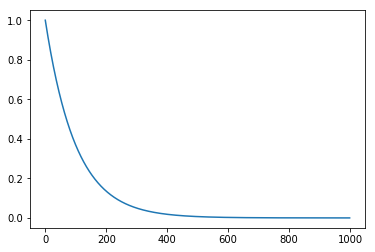

In [164]:
epsilon_initial = 1.0
epsilon_final = 0.
MAX_NUM_EPISODES = exp['epi']
print(MAX_NUM_EPISODES)
MAX_STEPS_PER_EPISODE = 50
linear_sched = LinearDecaySchedule(initial_value = epsilon_initial,
                                final_value = epsilon_final,
                                max_steps = MAX_NUM_EPISODES )
epsilon = [linear_sched(step) for step in range(MAX_NUM_EPISODES )]
plt.plot(epsilon)
plt.show()

In [165]:
linear_sched(600)

0.0024787521766663585

In [166]:
linear_sched(300)

0.049787068367863944

### Environment

In [167]:
# TOOLS

def isin2D(a, b):
    """
        Check the existance of elements of a in b
        return an array : a boolean for each element of a
    """
    boolArray = []
    for i in a:
        present = False
        j = 0
        while present == False and j < len(b):

            if np.array_equal(i, b[j]):
                present = True
            j += 1
        boolArray.append(present)
    return boolArray

In [168]:
from collections import deque
from collections import defaultdict

class Environment:
    def __init__(self, Job):
        self.job = Job

        self.state = None
        self.reward = None
        self.done = False
        self.actions = action_space(exp['data_dimension'], exp['max_skip'])
        #print(self.actions)
        self.def_actions()
        self.d = deque([], maxlen=exp['queue_length'])
        self.reset_env()
        self.valid_actions =defaultdict(list)
        self.actions_possible()
        

    def def_actions(self):
        """
            Define all combinations possibles with 3 numbers in {-2,0,2}
            Creates the list in self.actions
        """
#         self.actions=[
#             [0,0],
#             [-1,0],
#             [1,0],
#             [0,1],
#             [0,-1]
#         ]
        
        return self.actions

    def check_if_action_possible(self, a):
        """
            For each action, check if it is possible to apply to the current state :
            apply the action on the currect state and check if the new state is defined
            in the run dataFrame !!!!!! WILL BE CHANGED !!!
        """
#         return np.arange(len(self.actions))
        result_actions = [np.add(self.state, a) ]
        possible = isin2D(result_actions, np.array(self.job.runs['collector']))
        #print(possible)
        return possible[0]
    
    def actions_possible(self):
        # get all states
        states = self.list_states()
        for state in states:
            # set state as the current state
            self.set_state(state)
            # save all actions possible
            self.valid_actions[str(state)] = self.check_actions_possible1()

        
    def get_reward(self, state):
        reward = -1000
        for r in self.job.runs.T:
            if np.array_equal(self.job.runs['collector'][r], state):
                state, reward = self.job.getStateAndRewardById(r)
        return reward
    
    def check_actions_possible1(self):
        """
            For each action, check if it is possible to apply to the current state :
            apply the action on the currect state and check if the new state is defined
            in the run dataFrame !!!!!! WILL BE CHANGED !!!
        """
        result_actions = [np.add(self.state, a) for a in self.actions]
        possible = isin2D(result_actions, np.array(
            self.job.runs['collector']))

        return np.where(np.array(possible) == True)[0]
    
    def check_actions_possible(self):
        return self.valid_actions[str(self.state)]

    def do_action(self, action_id, esp=1, verbose = False, train=True):
        """
            Apply the action defined by action_id.
            Changes the current_state
            Returns (new_state,reward of the action, Done boolean, debug info)
        """
        if not action_id in self.check_actions_possible():
            #print('Something terribly wrong , State {} , Action_id {} '.format(self.state, action_id))
            return (None, -1000, self.decide_done(action_id), {}, action_id)

        params_actual = self.state
        action = self.actions[action_id]
        new_action = action

        new_params = np.add(params_actual, (np.array(new_action)))
        for r in self.job.runs.T:
            if np.array_equal(self.job.runs['collector'][r], new_params):
                self.state, self.reward = self.job.getStateAndRewardById(r)
                if verbose:
                    print("New state : {0} {1} duration {2}".format(r,self.state,self.job.runs['duration'][r]))
                return (self.state, self.reward, self.decide_done(action_id), {}, action_id)

        raise Exception('Pas normal pour le moment !!!')
        return None
    
    def reset_env(self):
        """ Initialize the environment to a random job """
        run_id = np.random.choice(self.job.runs.T.keys())
        self.state, self.reward = self.job.getStateAndRewardById(run_id)
        
        self.previous_action = None
        self.nb_actions = 0
        
        return self.state
    
    def set_state(self,state):
        self.reset_env()
        self.state = state
        return state
    
    def decide_done(self,a):
        """
            Decide when the environment is done:
            - no convergence : more than 50 actions since reset
            - stay on the same state more than twice            
        """
        
        self.nb_actions+=1
        action = self.actions[a]
        if exp['mode']==EPISODE:
            done = self.nb_actions > 50
        else:
            done = self.nb_actions > int(exp['num_step'])
        return done
    
    def list_states(self):
        params = np.array(self.job.runs['collector'])
        return params
        

env = Environment(job1)

In [169]:
print(env.reset_env())

env.check_actions_possible()

[-1, -5]


array([0, 1, 2, 4])

In [170]:
env.actions

[[0, 0], [-1, 0], [1, 0], [0, -1], [0, 1]]

In [171]:
import keras
from keras.models import Model
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Masking, CuDNNLSTM, Dropout, Activation, Input, Concatenate

In [172]:
from keras import backend as K
import tensorflow as tf

# # allocate only a part of the GPU
# config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.05
# config.log_device_placement = True
# config.allow_soft_placement = True
# sess = tf.Session(config=config)
# K.set_session(sess)

In [173]:
class Memory:
    """
        Memory class used by the deep agent during learning.
        The memory is a queue of fixed length to save a the transitions done by the agent :
        (cuurent_state, action taken, obtained reward, next state, environment done)
        It allows to :
            - add a new transition
            - get a set of random transitions
            - store the actions taken in each state
            - store the optimum state
    """

    def __init__(self, capacity, nb_actions):
        """
            Initializes the empty memory

            Args :
                capacity: Max number of transitions stored
                nb_actions: number of possible actions in each state
        """
        self.capacity = capacity
        self.nb_actions = nb_actions
        self.memory = list()

        self.memory_actions = dict()  # dict of arrays indexed by the actions
        self.memory_best = list()  # contains the list action 0 of the best states

    def append(self, state, action, reward, next_state, done):
        """
            Adds a new transition into the memory

            Args:
                state (array)
                action (integer 0<=action<nb_actions)
                reward (float)
                next_state (array)
                done (boolean)
        """
        # remove the first element of the memory if full
        if len(self.memory) > self.capacity:
            self.pop()

        self.memory.append((state, action, reward, next_state, done))

        # append in memory_actions dict
        state = np.array(state)
        # to index the dict (tobytes from the numpy lib)
        key_dict = state.tobytes() # an array is unhashable, a better solution need to be found
        if key_dict not in self.memory_actions.keys():
            # for each state : array counting the number of times an action was taken
            self.memory_actions[key_dict] = np.zeros(self.nb_actions)
        self.memory_actions[key_dict][action] += 1

        # new best list: if best empty or if better than known best
        nb_mem_best = len(self.memory_best)
        if nb_mem_best == 0 or self.memory_best[0][2] < reward:
            self.memory_best = list()
            # artifically creates a new transition to stay on the optimum
            self.memory_best.append((next_state, 0, reward, next_state, False))
        # if equal to best reward : append to the list
        elif nb_mem_best > 0 and self.memory_best[0][2] == reward:
            self.memory_best.append((next_state, 0, reward, next_state, False))

    def pop(self):
        """
            Removes the first transition in the memory
        """
        old_elem = self.memory[0]
        state_key = old_elem[0].tobytes()
        action = old_elem[1]
        self.memory.pop(0)
        # remove the action from the dict of actions taken
        self.memory_actions[state_key][action] -= 1

    def sample(self, n_total, n_best):
        """
            Samples randomly elements from the memory (both the transition and the best memory)

            Args :
                n_total : number of sample returned
                n_best : Among the sample returned, number of sample taken from the best memory

            Returns:
                array of transitions
        """
        # select n_total-n_best elements from memory
        idxs = np.random.choice(np.arange(len(self.memory)), size=n_total - n_best)
        mem_samples = np.array(self.memory)[idxs]

        # select n_best elements from best list
        idx_best = np.random.choice(np.arange(len(self.memory_best)), size=n_best)
        mem_best = np.array(self.memory_best)[idx_best]

        # merge the two list
        full = np.append(mem_samples, mem_best, axis=0)
        return full

    def list_actions_for_state(self, state):
        """
            Returns, for a given state, the list of action that were already taken.

            Args :
                state : state in question

            Returns :
                Array of actions index
        """
        state_key = np.array(state).tobytes()
        actions = []
        if state_key in self.memory_actions.keys():
            actions = np.where(self.memory_actions[state_key] > 0)[0]

        return np.array(actions)

       

# Actor Critic

In [174]:
import keras.backend as K

from keras.models import Model, load_model
from keras.layers import Input, Dense, Flatten
from keras.optimizers import Adam, RMSprop
from keras.utils import to_categorical
import tensorflow as tf

## Utils

In [175]:
def gather_stats(agent, env):
  """Compute average rewards over 10 episodes"""
  score = []
  for k in range(10):
      old_state = np.array(env.reset_env())
      cumul_r, done = 0, False
      while not done:
          a = agent.policy_action(old_state)
          new_state, r, done, _,_ = env.do_action(a)
          if np.array(new_state).any()!= None:
              old_state = np.array(new_state)
          cumul_r += r
      score.append(cumul_r)
  return np.mean(np.array(score)), np.std(np.array(score))



def tfSummary(tag, val):
    """ Scalar Value Tensorflow Summary
    """
    return tf.Summary(value=[tf.Summary.Value(tag=tag, simple_value=val)])

### Agent

In [176]:
class Agent:
    """ Agent Generic Class
    """

    def __init__(self, inp_dim, out_dim, lr):
        self.inp_dim = inp_dim
        self.out_dim = out_dim
        self.rms_optimizer =  RMSprop(lr=lr, epsilon=0.1, rho=0.99)

    def fit(self, inp, targ):
        """ Perform one epoch of training
        """
        self.model.fit(self.reshape(inp), targ, epochs=1, verbose=0)

    def predict(self, inp):
        """ Critic Value Prediction
        """
        return self.model.predict(self.reshape(inp))
        #return self.model.predict(inp)

    def reshape(self, x):
        if len(x.shape) < 2: return np.expand_dims(x, axis=0)
        else: return x

### Actor

In [177]:
class Actor(Agent):
    """ Actor for the A2C Algorithm
    """

    def __init__(self, inp_dim, out_dim, network, lr):
        Agent.__init__(self, inp_dim, out_dim, lr)
        self.model = self.addHead(network)
        self.action_pl = K.placeholder(shape=(None, self.out_dim))
        self.advantages_pl = K.placeholder(shape=(None,))
    def addHead(self, network):
        """ Assemble Actor network to predict probability of each action
        """
        x = Dense(128, activation='relu')(network.output)
        out = Dense(self.out_dim, activation='softmax')(x)
        return Model(network.input, out)

    def optimizer(self):
        """ Actor Optimization: Advantages + Entropy term to encourage exploration
        (Cf. https://arxiv.org/abs/1602.01783)
        """
        weighted_actions = K.sum(self.action_pl * self.model.output, axis=1)
        eligibility = K.log(weighted_actions + 1e-10) * K.stop_gradient(self.advantages_pl)
        entropy = K.sum(self.model.output * K.log(self.model.output + 1e-10), axis=1)
        loss = 0.001 * entropy - K.sum(eligibility)

        updates = self.rms_optimizer.get_updates(self.model.trainable_weights, [], loss)
        return K.function([self.model.input, self.action_pl, self.advantages_pl], [], updates=updates)

    def save(self, path):
        self.model.save_weights(path + '_actor.h5')

    def load_weights(self, path):
        self.model.load_weights(path)

### Critic

In [178]:
class Critic(Agent):
    """ Critic for the A2C Algorithm
    """

    def __init__(self, inp_dim, out_dim, network, lr):
        Agent.__init__(self, inp_dim, out_dim, lr)
        self.model = self.addHead(network)
        self.discounted_r = K.placeholder(shape=(None,))

    def addHead(self, network):
        """ Assemble Critic network to predict value of each state
        """
        x = Dense(128, activation='relu')(network.output)
        out = Dense(1, activation='linear')(x)
        return Model(network.input, out)

    def optimizer(self):
        """ Critic Optimization: Mean Squared Error over discounted rewards
        """
        critic_loss = K.mean(K.square(self.discounted_r - self.model.output))
        updates = self.rms_optimizer.get_updates(self.model.trainable_weights, [], critic_loss)
        return K.function([self.model.input, self.discounted_r], [], updates=updates)

    def save(self, path):
        self.model.save_weights(path + '_critic.h5')

    def load_weights(self, path):
        self.model.load_weights(path)

## A2C

In [179]:
class A2C:
    """ Actor-Critic Main Algorithm
    """

    def __init__(self, act_dim, env_dim, gamma = 0.99, lr = 0.0001):
        """ Initialization
        """
        # Environment and A2C parameters
        self.act_dim = act_dim
        self.env_dim = env_dim
        self.gamma = gamma
        self.lr = lr
        # Create actor and critic networks
        self.shared = self.buildNetwork()
        self.actor = Actor(self.env_dim, act_dim, self.shared, lr)
        #print(self.shared.summary())
        self.critic = Critic(self.env_dim, act_dim, self.shared, lr)
        # Build optimizers
        self.a_opt = self.actor.optimizer()
        self.c_opt = self.critic.optimizer()

    def buildNetwork(self):
        """ Assemble shared layers
        """
        inp = Input((self.env_dim))
        #x = Flatten()(inp)
    
        x = Dense(64, activation='relu')(inp)
        x = Dense(128, activation='relu')(x)
        return Model(inp, x)

    def policy_action(self, s):
        """ Use the actor to predict the next action to take, using the policy
        """
        return np.random.choice(np.arange(self.act_dim), 1, p=self.actor.predict(s).ravel())[0]

    def discount(self, r):
        """ Compute the gamma-discounted rewards over an episode
        """
        discounted_r, cumul_r = np.zeros_like(r), 0
        for t in reversed(range(0, len(r))):
            cumul_r = r[t] + cumul_r * self.gamma
            discounted_r[t] = cumul_r
        return discounted_r

    def train_models(self, states, actions, rewards, done):
        """ Update actor and critic networks from experience
        """
        # Compute discounted rewards and Advantage (TD. Error)
        discounted_rewards = self.discount(rewards)
        state_values = self.critic.predict(np.array(states))
        advantages = discounted_rewards - np.reshape(state_values, len(state_values))
        # Networks optimization
        self.a_opt([states, actions, advantages])
        self.c_opt([states, discounted_rewards])

    def train(self, env,nb_episodes, summary_writer):
        """ Main A2C Training Algorithm
        """

        results = []
        visited_states = []
        # Main Loop
        for e in range(nb_episodes):
            print('Episode {}/{}'.format(e, nb_episodes))
            # Reset episode
            time, cumul_reward, done = 0, 0, False
            old_state = np.array(env.reset_env())
            actions, states, rewards = [], [], []

            while not done:
                # Actor picks an action (following the policy)
                a = self.policy_action(old_state)
 
                # Retrieve new state, reward, and whether the state is terminal
                new_state, r, done, _,_ = env.do_action(a)
                #print(old_state, new_state, r, a)
                # Memorize (s, a, r) for training
                
                
                
                # Update current state
                if new_state!= None:
                    #print('q', old_state, )
                    actions.append(to_categorical(a, self.act_dim))
                    states.append(old_state)
                    rewards.append(r)
                    old_state = np.array(new_state)

                cumul_reward += r
                time += 1
                visited_states.append(states)
                

            mean, stdev = gather_stats(self, env)
            results.append([e, mean, stdev])

            # Export results for Tensorboard
            score = tfSummary('score', cumul_reward)
            summary_writer.add_summary(score, global_step=e)
            summary_writer.flush()
            
#             if done:
#                 print(states, np.array(states).shape)
            # Train using discounted rewards ie. compute updates
            self.train_models(states, actions, rewards, done)

        return {"states_visited":visited_states}

    def save_weights(self, path):
        path += '_LR_{}'.format(self.lr)
        self.actor.save(path)
        self.critic.save(path)

    def load_weights(self, path_actor, path_critic):
        self.critic.load_weights(path_critic)
        self.actor.load_weights(path_actor)

In [180]:
import time
from time import strftime

In [181]:
summary_writer = tf.summary.FileWriter("tensorboard" )
agent = A2C(act_dim= 2, env_dim=(2,), gamma = 0.99, lr = 0.01)
states = env.list_states()
t0 = time.time()
res= agent.train(env, 100, summary_writer)
t1 = time.time()
print("done {0}".format((t1-t0)/60))

Episode 0/100
Episode 1/100
Episode 2/100
Episode 3/100
Episode 4/100
Episode 5/100
Episode 6/100
Episode 7/100
Episode 8/100
Episode 9/100
Episode 10/100
Episode 11/100
Episode 12/100
Episode 13/100
Episode 14/100
Episode 15/100
Episode 16/100
Episode 17/100
Episode 18/100
Episode 19/100
Episode 20/100
Episode 21/100
Episode 22/100
Episode 23/100
Episode 24/100
Episode 25/100
Episode 26/100
Episode 27/100
Episode 28/100
Episode 29/100
Episode 30/100
Episode 31/100
Episode 32/100
Episode 33/100
Episode 34/100
Episode 35/100
Episode 36/100
Episode 37/100
Episode 38/100
Episode 39/100
Episode 40/100
Episode 41/100
Episode 42/100
Episode 43/100
Episode 44/100
Episode 45/100
Episode 46/100
Episode 47/100
Episode 48/100
Episode 49/100
Episode 50/100
Episode 51/100
Episode 52/100
Episode 53/100
Episode 54/100
Episode 55/100
Episode 56/100
Episode 57/100
Episode 58/100
Episode 59/100
Episode 60/100
Episode 61/100
Episode 62/100
Episode 63/100
Episode 64/100
Episode 65/100
Episode 66/100
Episo

In [184]:
res['states_visited'][99]

[array([1, 5]),
 array([1, 5]),
 array([1, 5]),
 array([1, 5]),
 array([1, 5]),
 array([1, 5]),
 array([1, 5]),
 array([1, 5]),
 array([1, 5]),
 array([1, 5]),
 array([1, 5]),
 array([1, 5]),
 array([1, 5]),
 array([1, 5]),
 array([1, 5]),
 array([1, 5]),
 array([1, 5]),
 array([1, 5]),
 array([1, 5]),
 array([1, 5]),
 array([1, 5]),
 array([1, 5]),
 array([1, 5]),
 array([1, 5]),
 array([1, 5]),
 array([1, 5]),
 array([1, 5]),
 array([1, 5]),
 array([1, 5]),
 array([1, 5]),
 array([1, 5]),
 array([1, 5]),
 array([1, 5]),
 array([1, 5]),
 array([1, 5]),
 array([1, 5]),
 array([1, 5]),
 array([1, 5]),
 array([1, 5]),
 array([1, 5]),
 array([1, 5]),
 array([1, 5]),
 array([1, 5]),
 array([1, 5]),
 array([1, 5]),
 array([1, 5]),
 array([1, 5]),
 array([1, 5]),
 array([1, 5]),
 array([1, 5]),
 array([1, 5])]

KeyError: 'loss'

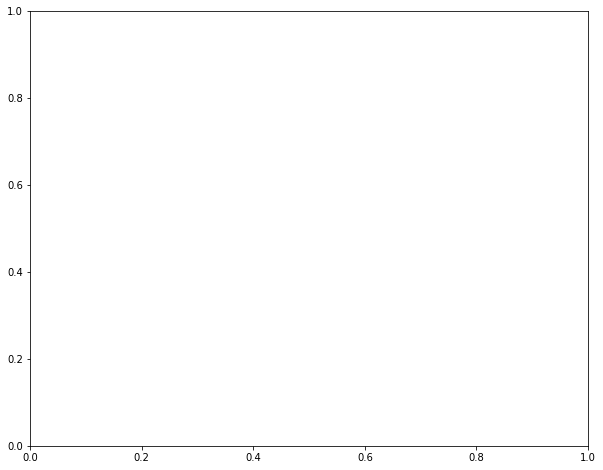

In [183]:
fig3, ax3 = plt.subplots(figsize=(10, 8))
loss_log = res['loss']
ax3.plot(range(len(loss_log)), loss_log, '-o')
plt.title("Total loss per episode")
plt.show()

In [ ]:
res['states_visited'][0]

In [ ]:
for x in range(exp['epi']):
    if len(res['states_visited'][x])<50:
        print(x+1)
        

In [ ]:
contoursteps(x1,x2, data, res['states_visited'][299])

In [ ]:
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def show(epi):
    contoursteps(x1,x2, data, res['states_visited'][epi])

In [ ]:
interact(show,epi=widgets.IntSlider(value=1, min=10, max=299, step=1))

In [ ]:
import pickle
def save_results(filename, data):
    filename = 'trained_results/'+filename +'.pkl'
    with open(filename, 'wb') as f:
        pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)
        
    return True
def load_results(filename):
    filename = 'trained_results/'+filename +'.pkl'
    with open(filename, 'rb') as f:
        b = pickle.load(f)
    return b

In [ ]:
#save_results('deep2d_5x5_32_32_new',res)

In [ ]:
#res =load_results('deep2d_5x5_32_32')

In [ ]:
contoursteps(x1,x2, data, res['states_visited'][299])

In [ ]:
res['states_visited'][299]

In [ ]:
nb = len(res['index_max_reward'])
t = np.arange(nb)
data1 = res['index_max_reward']
MAX_EPSILON = 1
MIN_EPSILON = 0.01
LAMBDA = 0.01 # speed of decay
data2 = [MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * math.exp(-LAMBDA * i) for i in range(nb)]

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('episode')
ax1.set_ylabel('steps', color=color)
ax1.scatter(t, data1, color=color, s=3)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('epsilon', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax1.set_title('Variation of the number of step to get the optimum with epsilon \nstart : {0} , lambda={1}'.format(states[80],LAMBDA))
fig.tight_layout()  # otherwise the right y-label is slightly clipped
# plt.legend()
plt.show()

In [ ]:
nb = len(res['index_max_reward'])
t = np.arange(nb)
data1 = res['nb_max']

MAX_EPSILON = 1
MIN_EPSILON = 0.01
LAMBDA = 0.01 # speed of decay
data2 = [MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * math.exp(-LAMBDA * step) for step in range(nb)]

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('episode')
ax1.set_ylabel('steps', color=color)
ax1.scatter(t, data1, color=color, s=3)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('epsilon', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax1.set_title('Variation of the number of step the agent stayed in the optimum per episode \nstart : {0} '.format(states[0]))
fig.tight_layout()  # otherwise the right y-label is slightly clipped
# plt.legend()
plt.show()

In [ ]:
nb = len(res['index_max_reward'])
t = np.arange(nb)
data1 = res['sum_rewards']

MAX_EPSILON = 1
MIN_EPSILON = 0.01
LAMBDA = 0.01 # speed of decay
data2 = [MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * math.exp(-LAMBDA * step) for step in range(nb)]

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('episode')
ax1.set_ylabel('sum', color=color)
ax1.scatter(t, data1, color=color, s=3)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('epsilon', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax1.set_title('Sum of rewards per episode \nstart : {0} '.format(states[80]))
fig.tight_layout()  # otherwise the right y-label is slightly clipped
# plt.legend()
plt.show()

In [ ]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [ ]:
dimFixe = 1 # dimension fixe : 1 for binsize
fixVal = states[1][80][dimFixe]
idx = np.where(np.array([i for i in job1.runs['accelerators']])[:,dimFixe]==fixVal)[0]
accels = [ i for i in np.array(job1.runs['accelerators'])[idx]]
accels = np.delete(accels, dimFixe, 1)

duration = 1/(np.array(job1.runs['durationNorm'])[idx]+0.02)

In [ ]:
def plot(list_episodes,index_episode,all_before=False,indicator='r-'):
    Z = duration.reshape(8, 5)
    fig, ax = plt.subplots()
    c = ax.pcolor(Z)
    fig.colorbar(c, ax=ax)

    if all_before == False:
        episodes = [list_episodes[index_episode]]
    else:
        episodes = np.array(list_episodes)[np.arange(index_episode+1)]
        
    for e in episodes:
        points = np.delete(np.array(e),dimFixe,1)
        ax.plot(points[:,0]/2-0.5,points[:,1]/2,indicator,alpha=0.5*1/len(episodes)+0.2)
    plt.show()

interact(plot, 
         list_episodes=fixed(res['states_visited']), 
         index_episode=widgets.IntSlider(min=0,max=len(res['states_visited'])-1,step=1,value=10),
         indicator = ['r-','r+']
        );

In [ ]:
## 50 Episodes
## liste des états dans list_states
s = np.array(env.set_state((states[0][80], states[1][80])))
list_states = []
list_states.append(s[1])
done = False
while not done:
    action = a.decision(s,0)
    next_s, r, done, _ = env.do_action(action)
    print(r)
    if not next_s is None:
        list_states.append(next_s[1])
    s = next_s
plot([list_states],0,all_before=False)